In [1]:
from __future__ import print_function

import numpy as np
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Convolution1D, MaxPooling1D
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from six.moves import cPickle as pickle
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, LambdaCallback

# fix random seed for reproducibility
np.random.seed(7)

NAME="LSTM-10.1"
split_valid_test=False

Using TensorFlow backend.


In [2]:
# Dane wejściowe
with open("X-sequences.pickle", 'rb') as f:
    X = pickle.load(f)
with open("Y.pickle", 'rb') as f:
    Y = pickle.load(f)
    

In [3]:
np.unique(Y)

array([  24,   37,  162,  231,  303,  325,  412,  573,  606,  665,  859,
        959, 1191, 1250, 1305, 1351, 1356, 1381, 1534, 1603, 1683, 1823,
       1833, 1903, 1983, 2153, 2183, 2234, 2344, 2584, 2655, 2687, 2694,
       2712, 2716, 2729, 2764, 2844, 2954, 4035, 4104, 4144, 4145, 4146])

W tej wersji eksperymentu, Y zawiera root_service - 44 unikalne kategorie główne. 
Zamieńmy je na liczby z przedziału 0-43

In [4]:
root_services=np.sort(np.unique(Y))
# skonstruuj odwrtotny indeks kategorii głównych
services_idx={root_services[i]: i for i in range(len(root_services))}

In [5]:
# Zamień 
Y=[services_idx[y] for y in Y]

In [6]:
Y=to_categorical(Y)
Y.shape

(22450, 44)

In [7]:
top_words = 6000
classes=Y[0,].shape[0]
print(classes)

44


In [8]:
# max_length (98th percentile is 476), padd the rest
max_length=500
X=sequence.pad_sequences(X, maxlen=max_length)


In [9]:
# slice in half even/odds to nulify time differencies
X_train=X[0:][::2] # even
X_test=X[1:][::2] # odds

Y_train=np.array(Y[0:][::2]) # even
Y_test=np.array(Y[1:][::2]) # odds

if split_valid_test:
    # Split "test" in half for validation and final testing
    X_valid=X_test[:len(X_test)/2]
    Y_valid=Y_test[:len(Y_test)/2]
    X_test=X_test[len(X_test)/2:]
    Y_test=Y_test[len(Y_test)/2:]
else:
    X_valid=X_test
    Y_valid=Y_test

In [9]:
# create the model
embedding_vecor_length = 128
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_length))
model.add(Dropout(0.25))
# model.add(Convolution1D(nb_filter=1024, filter_length=3, border_mode='same', activation='relu'))
# model.add(MaxPooling1D(pool_length=2))
# model.add(Convolution1D(nb_filter=512, filter_length=3, border_mode='same', activation='relu'))
# model.add(MaxPooling1D(pool_length=2))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(classes, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())


# Callbacks
early_stop_cb = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

checkpoit_cb = ModelCheckpoint(NAME+".h5", save_best_only=True)

# Print the batch number at the beginning of every batch.
batch_print_cb = LambdaCallback(on_batch_begin=lambda batch, logs: print (".",end=''), 
                                on_epoch_end=lambda batch, logs: print (batch))

# Plot the loss after every epoch.
plot_loss_cb = LambdaCallback(on_epoch_end=lambda epoch, logs: 
                              print (epoch, logs))
                              #plt.plot(np.arange(epoch), logs['loss']))

print("done")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          768000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 44)                4444      
Total params: 864,044
Trainable params: 864,044
Non-trainable params: 0
_________________________________________________________________
None
done


In [10]:
history = model.fit(
        X,#_train,
        Y,#_train,
        epochs=50,
        batch_size=1024,
        #validation_data=(X_valid,Y_valid),
        validation_split=0.3,
        callbacks=[early_stop_cb, checkpoit_cb, batch_print_cb, plot_loss_cb],
        verbose=0
        )

#history=model.fit(X_train, Y_train, validation_data=(X_test, Y_test), nb_epoch=3, batch_size=512)

................0
0 {'acc': 0.30603283721860225, 'loss': 3.6439972524957316, 'val_acc': 0.13479810068273204, 'val_loss': 3.100206742094135}
................1
1 {'acc': 0.32779686858639762, 'loss': 2.6346146135486781, 'val_acc': 0.38732185365185318, 'val_loss': 2.2789429213825145}
................2
2 {'acc': 0.40728013307914429, 'loss': 2.1687355504261108, 'val_acc': 0.38539192200839661, 'val_loss': 2.0784195471829303}
................3
3 {'acc': 0.46900852665398068, 'loss': 1.9759234166470014, 'val_acc': 0.48678740965215722, 'val_loss': 1.9026343896100186}
................4
4 {'acc': 0.53073692289156749, 'loss': 1.7824167102230131, 'val_acc': 0.54349762456150918, 'val_loss': 1.7133478138622364}
................5
5 {'acc': 0.55638284274028793, 'loss': 1.6503025617735432, 'val_acc': 0.54453681823476763, 'val_loss': 1.6734852479359317}
................6
6 {'acc': 0.58845615415031771, 'loss': 1.5389786299151653, 'val_acc': 0.55671021575882429, 'val_loss': 1.6121934321034266}
..............

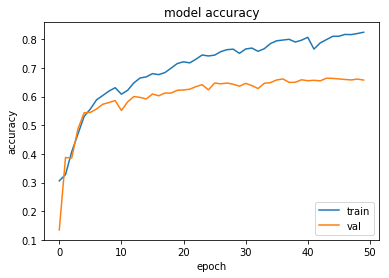

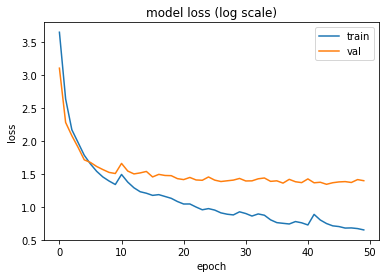

In [13]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss (log scale)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
#plt.yscale('log')
plt.show()

In [12]:

history2 = model.fit(
        X,#_train,
        Y,#_train,
        initial_epoch=10,    
        epochs=50,
        batch_size=1024,
        #validation_data=(X_valid,Y_valid),
        validation_split=0.3,
        callbacks=[early_stop_cb, checkpoit_cb, batch_print_cb, plot_loss_cb],
        verbose=0
        )    

................10
10 {'acc': 0.62479317930191702, 'loss': 1.325670536562461, 'val_acc': 0.56873516048218464, 'val_loss': 1.5279373791325404}
................11
11 {'acc': 0.633193331591968, 'loss': 1.2977991939516518, 'val_acc': 0.56680522834320246, 'val_loss': 1.5148598394597794}
................12
12 {'acc': 0.64019345678839501, 'loss': 1.2726139246818142, 'val_acc': 0.57437648838319577, 'val_loss': 1.5090631645818788}
................13
13 {'acc': 0.64222985826953305, 'loss': 1.2672030341766316, 'val_acc': 0.57407958136601578, 'val_loss': 1.509736040992012}
................14
14 {'acc': 0.65018454890101252, 'loss': 1.247774106348321, 'val_acc': 0.57986935782036131, 'val_loss': 1.4961168780179601}
................15
15 {'acc': 0.65336642468477824, 'loss': 1.221655653089577, 'val_acc': 0.59040974055786311, 'val_loss': 1.4965298113517127}
................16
16 {'acc': 0.63828433204792645, 'loss': 1.2865681063056189, 'val_acc': 0.54572447122134393, 'val_loss': 1.6003667051038946}
.....

In [13]:
score=model.evaluate(X_test,Y_test, verbose=0)
print("OOS %s: %.2f%%" % (model.metrics_names[1], score[1]*100))
print("OOS %s: %.2f" % (model.metrics_names[0], score[0]))

NameError: name 'X_test' is not defined

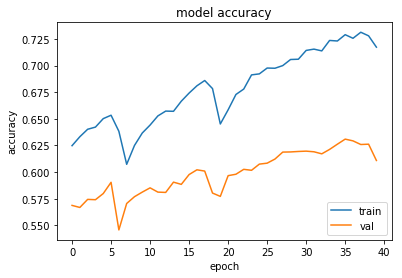

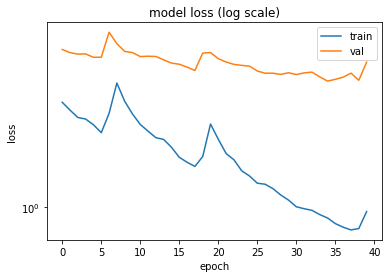

In [13]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()


# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss (log scale)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.yscale('log')
plt.show()

In [15]:
history3 = model.fit(
        X,#_train,
        Y,#_train,
        initial_epoch=60,    
        epochs=90,
        batch_size=1024,
        #validation_data=(X_valid,Y_valid),
        validation_split=0.3,
        callbacks=[early_stop_cb, checkpoit_cb, batch_print_cb, plot_loss_cb],
        verbose=0
        )

................60
60 {'acc': 0.69396716357036081, 'loss': 1.0682002606852541, 'val_acc': 0.61906176239181299, 'val_loss': 1.4453319599962575}
................61
61 {'acc': 0.7037037048871484, 'loss': 1.0332637657505632, 'val_acc': 0.61564727237275552, 'val_loss': 1.4414969362725554}
................62
62 {'acc': 0.70701285371711209, 'loss': 1.0041220267947522, 'val_acc': 0.62232779267281646, 'val_loss': 1.4268438312050282}
................63
63 {'acc': 0.71197658232548955, 'loss': 0.99611397675313584, 'val_acc': 0.62262470591946051, 'val_loss': 1.4255109716764256}
................64
64 {'acc': 0.71834033401439978, 'loss': 0.97293814648437305, 'val_acc': 0.62069477901889136, 'val_loss': 1.4260232516535671}
................65
65 {'acc': 0.72184039811467771, 'loss': 0.97190722480626812, 'val_acc': 0.61935867436424852, 'val_loss': 1.4186554088162131}
................66
66 {'acc': 0.72578592269766862, 'loss': 0.94906096593772571, 'val_acc': 0.62024940674208684, 'val_loss': 1.40941029149959

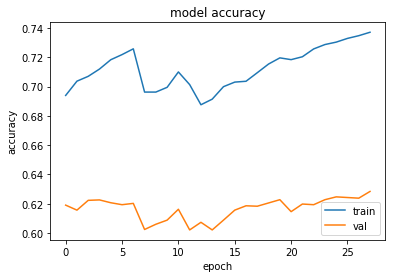

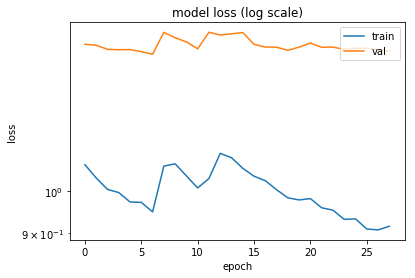

In [16]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history3.history['acc'])
plt.plot(history3.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()


# summarize history for loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss (log scale)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.yscale('log')
plt.show()